**Further train DeepCell Models with K's Data and Make Predictions**<br>
Starting from tn nuclear, further train with K's data cut into 7x25=175 512x512 patches.<br>
200 epochs, semanticdatagenerator, not resized<br>
Best mAP 0.xx at mpp=xx

In [1]:
starting_model_path = 'tn1.0_nuclear_20221102.h5' # the model trained with nucleus data from the Tissuenet V1.0 dataset
model_name = 'tn1.0_nuclear_K_512x512_25'
model_path = '{}.h5'.format(model_name)
epochs=200 # 20 sec per step 
INPUT_PATH="images/training_512x512_25/"

In [6]:
import syotil

import numpy as np
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from timeit import default_timer
import os
from skimage import img_as_ubyte

import deepcell
from deepcell import image_generators
from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell_toolbox.utils import resize, tile_image, untile_image
from deepcell_toolbox.deep_watershed import deep_watershed
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

print(tf.__version__)
print(deepcell.__version__)

2.7.1
0.11.1


In [9]:
import glob
FILENAMES = glob.glob(INPUT_PATH+"*_img.png")
print(len(FILENAMES))
print(FILENAMES[0:2])

imgs = [io.imread(CURR_IM_NAME)[:,:] for CURR_IM_NAME in FILENAMES]
X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

masks = [io.imread(CURR_IM_NAME.replace("img","masks")) for CURR_IM_NAME in FILENAMES]
y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

175
['images/training_512x512_25/M872956_JML_Position8_CD8_train21_img.png', 'images/training_512x512_25/M872956_JML_Position10_CD3_train13_img.png']


2022-11-05 09:49:59.451391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0


(175, 512, 512, 1)


2022-11-05 09:49:59.452831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-05 09:49:59.454012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


(175, 512, 512, 1)


In [10]:
# create dataloader

seed=0
min_objects = 5

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}

# use augmentation for training but not validation
# no need to define width_shift_range or height_shift_range 
# because crops will be taken randomly over the image and not just the center (cropping.py)
# datagen = image_generators.CroppingDataGenerator(
#     crop_size=(512, 512),
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.CroppingDataGenerator()

batch_size = 4 # 8 causes memory outage

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = None
# datagen_val.flow(
#     {'X': X_val, 'y': y_val},
#     seed=seed,
#     transforms=transforms,
#     transforms_kwargs=transforms_kwargs,
#     min_objects=min_objects,
#     batch_size=batch_size)

313596


In [14]:
mask_cnt=[len(np.unique(x)) for x in masks]
print(np.sort(mask_cnt))
indices = [mask_cnt.index(21)]
print(indices)

[ 21  23  42  42  47  66  67  73  74  74  78  79  79  84  90 100 105 108
 113 118 120 130 130 132 140 149 149 151 151 151 157 158 161 162 167 177
 178 179 184 191 198 203 216 223 235 244 271 273 274 275 277 279 283 285
 292 293 295 298 299 300 300 303 312 313 319 322 323 326 335 339 340 344
 349 349 350 352 354 358 359 359 360 361 369 371 372 373 373 386 386 388
 388 390 391 392 393 394 396 403 403 406 406 408 408 411 412 414 426 426
 429 433 435 436 438 439 447 450 452 455 457 460 468 475 483 485 503 507
 507 510 513 515 515 516 517 519 520 520 524 528 529 534 543 556 560 563
 566 568 569 575 578 585 585 592 608 609 615 615 626 629 639 644 659 661
 681 687 693 695 698 703 713 717 725 731 734 782 787]
[151]


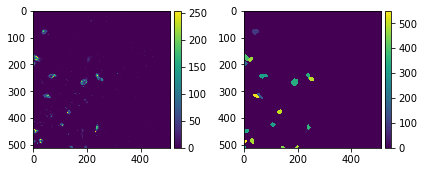

In [15]:
i=151
plt.subplot(1, 2, 1) # row 1, col 2 index 1
io.imshow(X_train[i,:,:,0])
plt.subplot(1, 2, 2) # row 1, col 2 index 1
# tmp = syotil.masks_to_outlines(y_train[i,:,:,0]); io.imshow(tmp)
io.imshow(y_train[i,:,:,0])
plt.show()

**The two cells below define and train the model.** They can be skipped if a trained model will be loaded.

In [16]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=(512,512,1),
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

model.load_weights(starting_model_path, by_name=True)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-11-05 09:51:44.760568: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[('semantic_0', (None, 512, 512, 1)),
 ('semantic_1', (None, 512, 512, 1)),
 ('semantic_2', (None, 512, 512, 2))]

In [17]:
# fit the model
print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
#     monitor="val_loss",
    # monitor='loss', # training loss
    verbose=1)          
            
loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size, # 
    epochs=epochs, 
#     validation_data=val_data,
#     validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

model.save_weights(model_path)

Training on 3 GPUs.


2022-11-05 09:51:53.327145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14657 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 7.0
2022-11-05 09:51:53.328213: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 14657 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2022-11-05 09:51:53.329256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 14657 MB memory:  -> device: 2, name: Tesla V100-PCIE-16GB, pci bus id: 0000:08:00.0, compute capability: 7.0


Epoch 1/200


2022-11-05 09:52:13.226571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


43/43 [==============================] - 82s 1s/step - loss: 0.0215 - semantic_0_loss: 0.0086 - semantic_1_loss: 0.0110 - semantic_2_loss: 0.0019 - lr: 1.0000e-04
Epoch 2/200
30/43 [===================>..........] - ETA: 13s - loss: 0.0196 - semantic_0_loss: 0.0078 - semantic_1_loss: 0.0101 - semantic_2_loss: 0.0016

KeyboardInterrupt: 

**Make prediction on K's data.**<br>
Using NuclearSegmentation allows setting image_mpp, which has a substantial influence on performance.

In [10]:
prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape= (512,512,1)
)

prediction_model.load_weights(model_path, by_name=True)

In [11]:
from deepcell.applications import NuclearSegmentation
app = NuclearSegmentation(prediction_model)
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), app.model.layers)]

[('semantic_0', (None, 512, 512, 1)), ('semantic_1', (None, 512, 512, 1))]

In [12]:
import os
print(os.getcwd())
INPUT_PATH="images/test/"
FILENAMES = [f for f in os.listdir("images/training/testimages")]
print(FILENAMES)

/home/yfong/deeplearning/dense_cell_segmentation
['M926910_CFL_Position7_CD3_test_img.png', 'M872956_JML_Position10_CD3_test_img.png', 'M872956_JML_Position8_CD8_test_img.png', 'M926910_CFL_Position13_CD3_test_img.png', 'M872956_JML_Position8_CD3_test_img.png', 'M872956_JML_Position8_CD4_test_img.png', 'M872956_JML_Position9_CD3_test_img.png']


In [16]:
# detailed mapping of image_mpp parameter
mpps = np.linspace(start=0.8, stop=1.5, num=8)
print(mpps)

AP_mat=[]
for CURR_IM_NAME in FILENAMES:
    print(CURR_IM_NAME)
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    AP_arr=[]
    for mpp in mpps:
        prd = app._untile_output(app.predict(y, image_mpp=mpp), tile_info)[0,:,:,0]
        a=syotil.csi(mask_true, prd)
        AP_arr.append(a)
    AP_mat.append(AP_arr)

#AP_mat
print(mpps)
[x.index(np.max(x)) for x in AP_mat]

[0.65 0.75 0.85 0.95 1.05 1.15 1.25]
M926910_CFL_Position7_CD3_test_img.png
M872956_JML_Position10_CD3_test_img.png
M872956_JML_Position8_CD8_test_img.png
M926910_CFL_Position13_CD3_test_img.png
M872956_JML_Position8_CD3_test_img.png
M872956_JML_Position8_CD4_test_img.png
M872956_JML_Position9_CD3_test_img.png
[0.65 0.75 0.85 0.95 1.05 1.15 1.25]


[5, 4, 2, 4, 2, 1, 4]

In [15]:
mpp_select=1

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    #plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.3236641221374046, 'M872956_JML_Position10_CD3_test_img.png': 0.3854166666666667, 'M872956_JML_Position8_CD8_test_img.png': 0.4330357142857143, 'M926910_CFL_Position13_CD3_test_img.png': 0.2606741573033708, 'M872956_JML_Position8_CD3_test_img.png': 0.4029126213592233, 'M872956_JML_Po

In [15]:
mpp_select=1.3

APs={}
for CURR_IM_NAME in FILENAMES:
    im0 = io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME))
    mask_true=io.imread(os.path.join(INPUT_PATH, CURR_IM_NAME.replace("img","masks")))

    x = np.expand_dims(im0, axis=-1)
    x = np.expand_dims(x, axis=0)
    y, tile_info = app._tile_input(x)
    pred = app.predict(y, image_mpp=mpp_select)
    prd = app._untile_output(pred, tile_info)
    #io.imshow(prd[0,:,:,0])
    #plt.show()
    
    APs[CURR_IM_NAME] = syotil.csi(mask_true, prd[0,:,:,0])# masks may lose one pixel if dimension is odd pixels

APs["mAP"]=np.mean(list(APs.values()))
print(APs)

(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
(1, 1040, 233, 1)
(1, 1568, 512, 1)
{'padding': True, 'x_pad': (264, 264), 'y_pad': (139, 140)}
{'M926910_CFL_Position7_CD3_test_img.png': 0.3236641221374046, 'M872956_JML_Position10_CD3_test_img.png': 0.3854166666666667, 'M872956_JML_Position8_CD8_test_img.png': 0.4330357142857143, 'M926910_CFL_Position13_CD3_test_img.png': 0.2606741573033708, 'M872956_JML_Position8_CD3_test_img.png': 0.4029126213592233, 'M872956_JML_Po

In [18]:
import pandas as pd
df = pd.DataFrame([FILENAMES+["mAP"], list(APs.values())])
print(df.transpose())
df.to_csv('images/training/csi_tn_'+model_name+'.txt', index=False, header=False)

                                         0         1
0   M926910_CFL_Position7_CD3_test_img.png  0.323664
1  M872956_JML_Position10_CD3_test_img.png  0.385417
2   M872956_JML_Position8_CD8_test_img.png  0.433036
3  M926910_CFL_Position13_CD3_test_img.png  0.260674
4   M872956_JML_Position8_CD3_test_img.png  0.402913
5   M872956_JML_Position8_CD4_test_img.png  0.439583
6   M872956_JML_Position9_CD3_test_img.png  0.356604
7                                      mAP  0.371699


**mAP**<br>
image_mpp=1:   0.37<br>
image_mpp=1.3: 0.30<br>